In [1]:
from neural_net.cbrain.model_diagnostics_PF import *
from neural_net.cbrain.data_generator import *
from neural_net.cbrain.legacy.losses import *
from neural_net.cbrain.utils import *
from preprocess.parsePF import *
from preprocess.preprocess_PF import *
import time

Using TensorFlow backend.


In [2]:
limit_mem()

In [3]:
# Create log string
log_str = create_log_str()

GitPython not found. Please install for better reproducibility.


In [6]:
MODEL_DIR = 'saved_models/'
model_name = '003_LW_3d_test.h5'

In [7]:
#load model
model_dense_6 = keras.models.load_model(MODEL_DIR+model_name, custom_objects={"tf": tf,
                                                                    "rmse":rmse,
                                                                     'log_loss': log_loss,
                                                                     "var_ratio":var_ratio,
                                                                     "var_loss":var_loss})

In [8]:
model_dense_4 = keras.models.load_model(MODEL_DIR+'001_LW_3d_test.h5', custom_objects={"tf": tf,
                                                                    "rmse":rmse,
                                                                     'log_loss': log_loss,
                                                                     "var_ratio":var_ratio,
                                                                     "var_loss":var_loss})

In [21]:
model_conv_lstm = keras.models.load_model(MODEL_DIR+'lstm_model_003.h5', custom_objects={"tf": tf,
                                                                    "rmse":rmse,
                                                                     'log_loss': log_loss,
                                                                     "var_ratio":var_ratio,
                                                                     "var_loss":var_loss})

In [10]:
in_dir = 'washita/tcl_scripts/Outputs1/'
in_file = 'washita/tcl_scripts/LW_Test.tcl'
pref_arg = 'LW_3d_test_seq'
itime = 0

In [11]:
#get initial information
nx,ny,nz,dx,dy,dz,dz_scale,time_arrays,lat0,lon0,lev0,var_outs = init_arrays(in_dir, in_file)

In [12]:
t1 = time.time()
target_arrs = init_arrays_with_press(in_dir, in_file)
t2 = time.time()
print('load target files '+str(t2-t1))

load target files 52.659323930740356


In [13]:
target_dataset = xr.Dataset(coords={'lat':lat0,'lon':lon0,'lev':lev0,'time':np.array([0,1])})
for k in list(target_arrs.keys()):
    target_dataset[k] = (['time','lev','lat','lon'],np.tile(target_arrs[k][itime],(2,1,1,1)))

target_da, target_names = create_feature_or_target_da(
                                                    target_dataset,
                                                    ['press','satur'],
                                                    0,
                                                    'target',
                                                    1,
                                                    flx_same_dt=False
                                                )
target_da = reshape_da(target_da)

In [14]:
idxs = np.array([i for i, n in enumerate(target_names.data) if 'press' in n])

In [15]:
#sample and batch size
batch_size = nx*ny
target_size = target_da.data.shape[1]
#steps = int(sample_size/batch_size)

In [16]:
reinforce_input_dataset = xr.Dataset(coords={'lat':lat0,'lon':lon0,'lev':lev0,'time':np.array(range(len(target_arrs['press'])))})
for k in list(var_outs.keys())[1:-1]:
    reinforce_input_dataset[k] = (['time','lev','lat','lon'],np.tile(var_outs[k],(len(target_arrs['press']),1,1,1)))

reinforce_input_dataset['precip'] = (['time','lev','lat','lon'],np.stack(var_outs['precip']))
reinforce_input_dataset['prev_press'] = (['time','lev','lat','lon'],np.stack([var_outs['prev_press']]+target_arrs['press'][:-1]))

In [17]:
t_2 = time.time()
reinforce_feature_da, reinforce_feature_names = create_feature_or_target_da(
            reinforce_input_dataset,
            ['prev_press','precip','slope_x','slope_y','perm','poros',
             'rel_perm_alpha','rel_perm_N',
             'satur_alpha','satur_N','satur_sres','satur_ssat',
             'tensor_x','tensor_y','tensor_z','spec_storage','mannings'],
            0,
            'feature',
            flx_same_dt=False
    )
#reshape feature
reinforce_feature_da = reshape_da(reinforce_feature_da)
t_3 = time.time()
print('creating time :'+str(t_3-t_2))

creating time :20.56120991706848


In [18]:
t_4 = time.time()
predict_dense4_onestep = model_dense_4.predict(reinforce_feature_da.data,batch_size=batch_size)
t_5 = time.time()
print('predict time : '+str(t_5-t_4))


predict time : 8.836779356002808


In [19]:
t_4 = time.time()
predict_dense6_onestep = model_dense_6.predict(reinforce_feature_da.data,batch_size=batch_size)
t_5 = time.time()
print('predict time : '+str(t_5-t_4))


predict time : 8.924233198165894


In [20]:
#input for lstm model
## file name
static_file = 'nc_file/LW_static.nc'
precip_file = 'nc_file/LW_precip.nc'
prev_press_file = 'nc_file/LW_prev_press.nc'
target_satur_file = 'nc_file/LW_satur.nc'
target_press_file = 'nc_file/LW_press.nc'
## forcing data
t5 = time.time()
forcing_input = xr.open_dataset(precip_file)
forcing_feature_da, forcing_feature_names = create_feature_or_target_da(
            forcing_input,
            ['precip'],
            0,
            'feature',
            flx_same_dt=True
    )

#adding channel dimension
forcing_feature_da = forcing_feature_da.data[:,0,:,:]
forcing_feature_da = forcing_feature_da[...,np.newaxis]
forcing_feature_da = forcing_feature_da[np.newaxis,...]
#merge_feature_da = merge_feature_da.data[np.newaxis,...]
t6 = time.time()
print('time to read forcing input data: '+str(np.around(t6-t5,3))+' s')

## static inputs
t1 = time.time()
static_input_xr = xr.open_dataset(static_file)
static_feature_da, static_feature_names = create_feature_or_target_da(
            static_input_xr,
            ['slope_x','slope_y','perm','poros',
             'rel_perm_alpha','rel_perm_N',
             'satur_alpha','satur_N','satur_sres','satur_ssat',
             'tensor_x','tensor_y','tensor_z','spec_storage','mannings'],
            0,
            'feature',
            flx_same_dt=True
    )

t2 = time.time()
####reshape feature
#static_feature_da = reshape_da(static_feature_da)
print('time to read static data: '+str(np.around(t2-t1,3))+' s')

## reduce input
t3 = time.time()
one_layer_feats = ['slope_x','slope_y','spec_storage','mannings',
                  'tensor_x','tensor_y','tensor_z']
new_static_feature_da = []
new_static_names = []
for ii,fname in enumerate(static_feature_names.data):
    if fname.split('_lev')[0] in one_layer_feats:
        if int(fname[-2:]) == 0:
            new_static_feature_da.append(static_feature_da[:,ii,:,:])
            new_static_names.append(fname)
        else:
            continue
    else:
        new_static_feature_da.append(static_feature_da[:,ii,:,:])
        new_static_names.append(fname)

new_static_feature_da = np.stack(new_static_feature_da,axis=0)
new_static_feature_da = np.swapaxes(new_static_feature_da,0,1)
new_static_feature_da = np.swapaxes(new_static_feature_da,1,2)
new_static_feature_da = np.swapaxes(new_static_feature_da,2,3)
new_static_feature_da = np.tile(new_static_feature_da,(forcing_feature_da.shape[1],1,1,1))
new_static_feature_da = new_static_feature_da[np.newaxis,...]
t4 = time.time()
print('time to reduce static input data: '+str(np.around(t4-t3,3))+' s')

## previous pressure level
t7 = time.time()
prev_press_input = xr.open_dataset(prev_press_file)
prev_press_feature_da, prev_press_feature_names = create_feature_or_target_da(
            prev_press_input,
            ['prev_press'],
            0,
            'feature',
            flx_same_dt=True
    )
prev_press_feature_da = np.swapaxes(prev_press_feature_da.data,1,2)
prev_press_feature_da = np.swapaxes(prev_press_feature_da,2,3)
prev_press_feature_da = prev_press_feature_da[np.newaxis,...]
t8 = time.time()
print('time to read previous press input data: '+str(np.around(t8-t7,3))+' s')

time to read forcing input data: 0.072 s
time to read static data: 0.241 s
time to reduce static input data: 2.055 s
time to read previous press input data: 1.227 s


In [42]:
t_6 = time.time()
predict_lstm_onestep = model_conv_lstm.predict(x=[new_static_feature_da,
                                                   prev_press_feature_da,
                                                   forcing_feature_da],batch_size=nx*ny)
predict_lstm_onestep_reshape = np.reshape(predict_lstm_onestep,(-1,target_size))
t_7 = time.time()
print('predict time : '+str(t_5-t_4))

predict time : 8.924233198165894


In [68]:
#start looping
list_p_lstm_multi = []
t3 = time.time()
for itime in range(len(target_arrs['press'])):
    if (itime % 100)==0:
        print(itime)
    tmp_static = new_static_feature_da[:,0,:,:,:][np.newaxis,...]
    tmp_static = np.swapaxes(tmp_static,0,1)
    tmp_forcing = forcing_feature_da[:,itime,:,:,:][np.newaxis,...]
    tmp_forcing = np.swapaxes(tmp_forcing,0,1)
    if itime == 0:
        tmp_prev_press = prev_press_feature_da[:,0,:,:,:][np.newaxis,...]
        tmp_prev_press = np.swapaxes(tmp_prev_press,0,1)
        tmp_p = model_conv_lstm.predict(x=[tmp_static,
                                           tmp_prev_press,
                                           tmp_forcing],batch_size=nx*ny)
    else:
        tmp_prev_press = tmp_prev_press[:,0,:,:,:][np.newaxis,...]
        tmp_prev_press = np.swapaxes(tmp_prev_press,0,1)
        tmp_p = model_conv_lstm.predict(x=[tmp_static,
                                           tmp_prev_press,
                                           tmp_forcing],batch_size=nx*ny)
    tmp_prev_press = np.reshape(tmp_p,(tmp_p.shape[0],tmp_p.shape[1],ny,nx,target_size))[:,:,:,:,:int(target_size/2)]
    list_p_lstm_multi.append(tmp_p)

t4 = time.time()
print('total run time: '+str(t4-t3))

0
100
200
300
400
500
600
700
800
900
1000
total run time: 10.905845880508423


In [74]:
#stacking the results
t6 = time.time()
lstm_multi = np.vstack(list_p_lstm_multi)
predict_lstm_multistep_reshape = np.reshape(lstm_multi,(-1,target_size))
#final_p = np.reshape(final_p,(ny,nx,int(np.floor(total_sample_size / batch_size)),target_size),'F')
t7 = time.time()
print('stacking time: '+str(t7-t6))

stacking time: 0.2557668685913086


In [75]:
predict_lstm_multistep_reshape.shape

(1682681, 100)

In [72]:
predict_lstm_onestep.shape
#predict_lstm_onestep_reshape.shape

(1, 1001, 168100)

In [39]:
#start looping
list_p_multi = []
total_sample_size = 0
t3 = time.time()
for itime in range(len(target_arrs['press'])):
    input_dataset = xr.Dataset(coords={'lat':lat0,'lon':lon0,'lev':lev0,'time':np.array([itime])})
    for k in list(var_outs.keys())[1:-1]:
        input_dataset[k] = (['time','lev','lat','lon'],var_outs[k][np.newaxis,...])
    if itime == 0:
        input_dataset['precip'] = (['time','lev','lat','lon'],var_outs['precip'][itime][np.newaxis,...])
        input_dataset['prev_press'] = (['time','lev','lat','lon'],var_outs['prev_press'][np.newaxis,...])
    else:
        input_dataset['precip'] = (['time','lev','lat','lon'],var_outs['precip'][itime][np.newaxis,...])
        input_dataset['prev_press'] = (['time','lev','lat','lon'],reshape_p[np.newaxis,...])
    #create feature dataset
    feature_da, feature_names = create_feature_or_target_da(
            input_dataset,
            ['prev_press','precip','slope_x','slope_y','perm','poros',
             'rel_perm_alpha','rel_perm_N',
             'satur_alpha','satur_N','satur_sres','satur_ssat',
             'tensor_x','tensor_y','tensor_z','spec_storage','mannings'],
            0,
            'feature',
            flx_same_dt=True
    )
    #reshape feature
    feature_da = reshape_da(feature_da)
    sample_size = feature_da.data.shape[0]
    total_sample_size += sample_size
    #normalize feature?
    """
    feature_da_norm = normalize_feature_da(
        feature_da, log_str, ext_norm=None, feature_names=feature_names,
        inputs=['prev_press','precip','slope_x','slope_y','perm','poros',
         'rel_perm_alpha','rel_perm_N',
         'satur_alpha','satur_N','satur_sres','satur_ssat',
         'tensor_x','tensor_y','tensor_z','spec_storage','mannings'], 
        norm_features=None)
    """
    #get prediction
    t4 = time.time()
    p = model_dense_6.predict(feature_da.data,batch_size=batch_size)
    t5 = time.time()
    if (itime % 100)==0:
        print('predict time for timestep #: '+str(itime)+' '+str(t5-t4))
    reshape_p = np.reshape(p,(ny,nx,int(np.floor(sample_size / batch_size)),target_size),'F')[:,:,0,idxs]
    reshape_p = np.swapaxes(reshape_p,2,1)
    reshape_p = np.swapaxes(reshape_p,0,1)
    reshape_p = reshape_p.transpose(0,2,1)
    list_p_multi.append(p)

t6 = time.time()
print('total run time: '+str(t6-t3))

predict time for timestep #: 0 0.0150146484375
predict time for timestep #: 100 0.007858991622924805
predict time for timestep #: 200 0.007577180862426758
predict time for timestep #: 300 0.009102344512939453
predict time for timestep #: 400 0.008948326110839844
predict time for timestep #: 500 0.00921940803527832
predict time for timestep #: 600 0.009325981140136719
predict time for timestep #: 700 0.009153366088867188
predict time for timestep #: 800 0.00897216796875
predict time for timestep #: 900 0.009043693542480469
predict time for timestep #: 1000 0.008989810943603516
total run time: 221.76321959495544


In [40]:
#stacking the results
dense_6_multi = np.vstack(list_p_multi)
#final_p = np.reshape(final_p,(ny,nx,int(np.floor(total_sample_size / batch_size)),target_size),'F')
t7 = time.time()
print('stacking time: '+str(t7-t6))

stacking time: 0.40166139602661133


In [32]:
#create target dataset
t7 = time.time()
target_dataset = xr.Dataset(coords={'lat':lat0,'lon':lon0,'lev':lev0,'time':np.arange(len(target_arrs['press']))})
for k in list(target_arrs.keys()):
    target_dataset[k] = (['time','lev','lat','lon'],np.stack(target_arrs[k],axis=0))

target_da, target_names = create_feature_or_target_da(
                                                    target_dataset,
                                                    ['press','satur'],
                                                    0,
                                                    'target',
                                                    1,
                                                    flx_same_dt=True
                                                )
target_da = reshape_da(target_da)
"""  
final_press_t = np.stack(target_arrs['press'][:-1],axis=0)
final_press_t = np.swapaxes(final_press_t,1,2)
final_press_t = np.swapaxes(final_press_t,0,1)
final_press_t = np.swapaxes(final_press_t,2,3)
final_press_t = np.swapaxes(final_press_t,1,2)
#target saturation
final_satur_t = np.stack(target_arrs['satur'][:-1],axis=0)
final_satur_t = np.swapaxes(final_satur_t,1,2)
final_satur_t = np.swapaxes(final_satur_t,0,1)
final_satur_t = np.swapaxes(final_satur_t,2,3)
final_satur_t = np.swapaxes(final_satur_t,1,2)
"""
t8 = time.time()
print('creating target dataset time: '+str(t8-t7))

creating target dataset time: 2.778284788131714


In [71]:
predict_dense4_onestep.shape

(1682681, 100)

In [76]:
diag1 = ModelDiagnostics([predict_dense4_onestep,
                          predict_dense6_onestep,
                         dense_6_multi,
                         predict_lstm_onestep_reshape,
                         predict_lstm_multistep_reshape],target_da.data,target_names.data,ny,nx,['press','satur'])

In [21]:
diag1.compute_stats()
diag1.mean_stats(2)

/glade/scratch/hoangtran/ssd_NN/NN/neural_net/cbrain/model_diagnostics_PF.py:190: RuntimeWarning: divide by zero encountered in true_divide
  self.stats['r2'] = 1. - (self.stats['mse'] / self.stats['true_var'])
/glade/scratch/hoangtran/ssd_NN/NN/neural_net/cbrain/model_diagnostics_PF.py:196: RuntimeWarning: divide by zero encountered in true_divide
  self.stats['hor_r2'] = 1 - (self.stats['hor_mse'] / self.stats['hor_tvar'])


,bias,mse,pred_mean,true_mean,pred_sqmean,true_sqmean,pred_var,true_var,r2,hor_tsqmean,hor_tmean,hor_mse,hor_tvar,hor_r2
press,-9.39781e-05,9.21571e-05,42.1229,42.123,2551.02,2551.03,0.000266808,0.000269011,-3.60703e+06,2551.03,42.123,9.21571e-05,35.7333,0.999991
satur,1.18776e-06,0.000118996,0.961772,0.96177,0.94877,0.948913,4.97241e-07,6.31595e-07,-inf,0.948913,0.96177,0.000118996,0.015245,-inf
all,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-inf


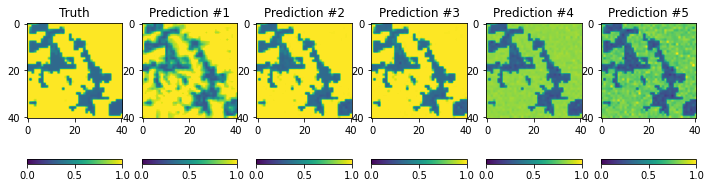

In [113]:
diag1.plot_double_xy(100,95,'satur',vmin=0,vmax=1)
plt.savefig('satur_10m.png', bbox_inches='tight')

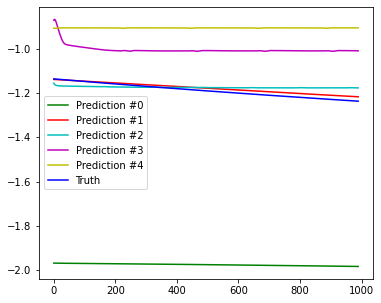

In [103]:
diag1.plot_hydrograph(18,20,49)
plt.savefig('hydrograph_18_20.png', bbox_inches='tight')

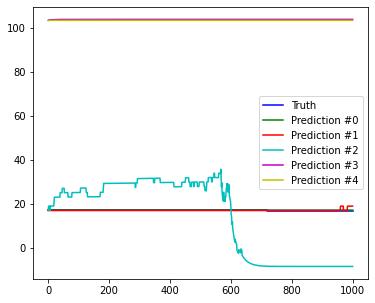

In [110]:
yi,xi = 17,15
diag1.plot_wtd(yi,xi,dz_scale,nz,dz)
plt.savefig('wtd_17_15.png', bbox_inches='tight')

(<Figure size 864x360 with 6 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x2b00bea119d0>,
       dtype=object))

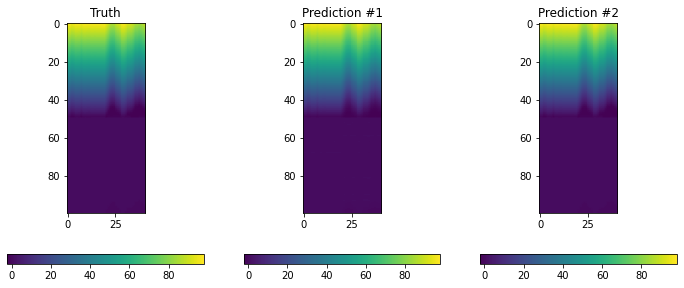

In [37]:
diag1.plot_double_yz(950,35,'press')

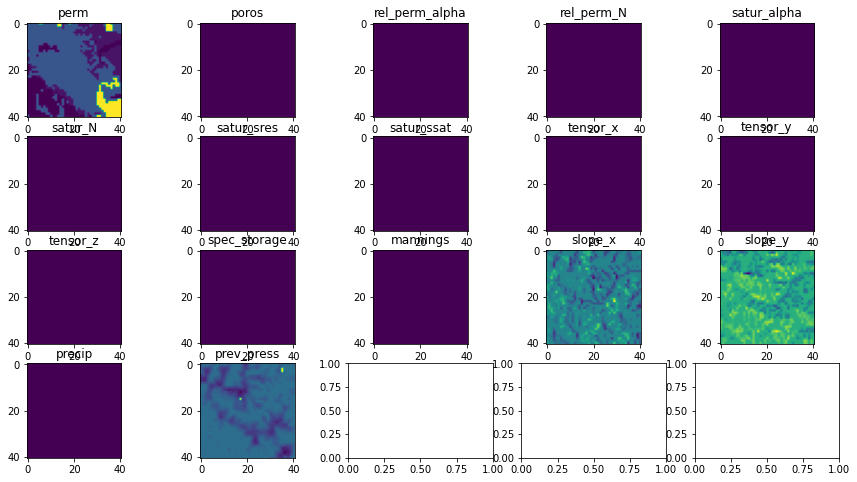

In [26]:
#visualize targets
fig,axs = plt.subplots(4,5,figsize=(15,8))
for ii,keyi in enumerate(input_dataset.data_vars):
    ax = axs[ii//5,ii%5]
    ax.imshow(input_dataset[keyi][0,0,:,:])
    ax.set_title(keyi)